In [129]:
import numpy as np
import scipy.stats as stats
import pandas as pd

def calculate_d2(n: int) -> float:
    standard_normal = stats.norm()
    approx_x, dx = np.linspace(-20.0, 20.0, 1001, retstep=True)
    sample_vals = (
        1.0
        - (1.0 - standard_normal.cdf(approx_x)) ** n
        - standard_normal.cdf(approx_x) ** n
    )
    return np.trapz(sample_vals, dx=dx)

def calculate_process(x, LSL, USL, window=8):
    mu = x.mean()
    std = x.std()
    r = x.rolling(window)
    Rbar = r.max() - r.min()
    std_within = (Rbar/calculate_d2(window)).mean()

    ppk = np.min([
        (USL-mu)/(3*std),
        (mu-LSL)/(3*std)
    ])
    
    cpk = np.min([
        (USL-mu)/(3*std_within),
        (mu-LSL)/(3*std_within)
    ])

    d = {
        "sample size": len(x),
        "mean": mu,
        "std": std,
        "std_within": std_within,
        "ppk": ppk,
        "cpk": cpk,
        "min": x.min(),
        "max": x.max()
    }
    return pd.Series(d, index=['sample size', 'mean', 'std', 'std_within', 'ppk', 'cpk', 'min', 'max'])

In [139]:
data = pd.read_excel("../data/raw/Lens Placement.xlsx")
LSL=-20
USL=20

In [140]:
y = data.LocationError.drop(labels=[2])
proc = calculate_process(y, LSL=-20, USL=20)
proc

sample size    19.000000
mean            5.315789
std            12.499123
std_within     11.473258
ppk             0.391606
cpk             0.426621
min           -19.000000
max            34.000000
dtype: float64

In [248]:
normal = stats.norm(loc=proc["mean"], scale=proc["std"])

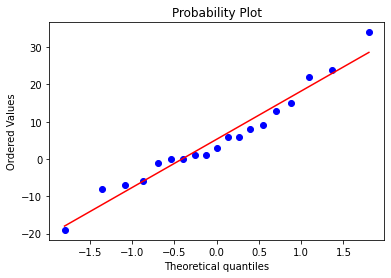

In [238]:
fig, ax = pl.subplots()
(exp, obs), (slope, intercept, r) = stats.probplot(y, plot=ax)

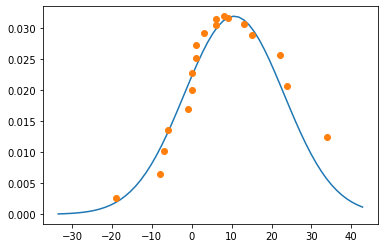

In [325]:
x = np.arange(-3, 3, .1)
pl.plot(slope * x + intercept, normal.pdf(slope * x))
pl.plot(obs, normal.pdf(exp * proc["std"]), "o")

In [346]:
p_value = np.mean(np.array([2. * min([1 - normal.cdf(_obs), normal.cdf(_obs)]) for _obs in obs]))
p_value

0.5327466903723929

In [347]:
stats.anderson(obs)

AndersonResult(statistic=0.3230273996665929, critical_values=array([0.505, 0.575, 0.69 , 0.804, 0.957]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

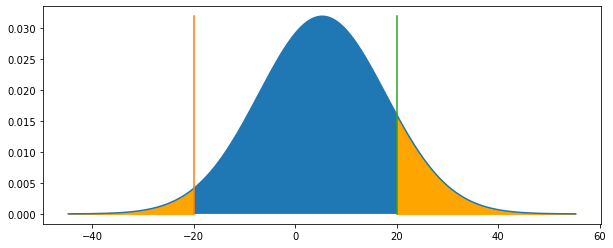

In [362]:
pl.figure(figsize=(10, 4))
x = np.arange(proc["mean"] - 4 * proc["std"], proc["mean"] + 4 * proc["std"], .1)
normal = stats.norm(loc=proc["mean"], scale=proc["std"])
pdf = normal.pdf(x)
pl.plot(x, pdf)
pl.plot([LSL, LSL], [0, pdf.max()])
pl.plot([USL, USL], [0, pdf.max()])
pl.fill_between(x, pdf)
pl.fill_between(x[x>USL], pdf[x>USL], color="orange")
pl.fill_between(x[x<LSL], pdf[x<LSL], color="orange")

In [363]:
proc

sample size    19.000000
mean            5.315789
std            12.499123
std_within     11.473258
ppk             0.391606
cpk             0.426621
min           -19.000000
max            34.000000
dtype: float64